# Conditional Variational Autoencoders (CVAE)

## What Are Autoencoders?

An **autoencoder** is a type of artificial neural network designed to learn efficient representations of data in an unsupervised manner. It operates by compressing input data into a smaller latent-space representation (encoding) and then reconstructing the data from this compressed representation (decoding). The goal is to minimize the reconstruction error, which measures the difference between the original input and its reconstruction. An example architecture of autoencoders is presented in the following figure:

![A figure depicting a generic autoencoder architecture](assets/autoencoder.png)

Autoencoders are commonly used for:
- **Dimensionality reduction:** Compressing data into lower-dimensional representations for visualization or as input for other algorithms.
- **Feature learning:** Learning latent features useful for classification, clustering, or other downstream tasks.
- **Anomaly detection:** Identifying unusual patterns by measuring reconstruction errors.
- **Data generation:** Synthesizing new data similar to the input distribution.

### Variants of Autoencoders

Autoencoders can be adapted for various applications through modifications to their architecture and training process:
1. **Regularized Autoencoders:**
    - **Sparse Autoencoders:** Impose sparsity constraints on the latent representation, forcing the model to learn only the most important features.
    - **Denoising Autoencoders:** Train the model to reconstruct original data from corrupted inputs, making the encoding robust to noise.
    - **Contractive Autoencoders:** Regularize the latent space by penalizing sensitivity to small input changes, improving feature robustness.
2. **Variational Autoencoders (VAEs):**
    - Used for probabilistic data generation. Instead of encoding inputs to a single point in the latent space, VAEs map them to a distribution (e.g., Gaussian), enabling smoother interpolation and sampling.

## Conditional Variational Autoencoders (CVAEs)

**Conditional Variational Autoencoders (CVAEs)** extend VAEs by incorporating additional conditional information (e.g., class labels). This conditioning allows the model to:
- Generate data conditioned on specific attributes, such as digits of a particular class in MNIST or specific fashion items in Fashion MNIST.
- Enhance control over the generated data.

In a CVAE, both the encoder and decoder take the conditional information as an additional input. This enables the model to produce samples specific to the given condition.

## Example: Conditional VAE on Fashion MNIST

In this example, we demonstrate how to implement a **Conditional VAE (CVAE)** using the **Fashion MNIST** dataset. The dataset contains grayscale images of various clothing items (e.g., shirts, shoes, and bags). The goal is to train a CVAE to generate new images conditioned on specific clothing categories.

### Key Steps:
1. **Dataset Preparation:** Load the Fashion MNIST dataset and preprocess it for training.
2. **Model Architecture:** Implement the encoder, decoder, and sampling functions for the CVAE using PyTorch.
3. **Training:** Train the CVAE using a combination of reconstruction loss (e.g., binary cross-entropy) and Kullback-Leibler (KL) divergence to enforce smooth latent distributions.
4. **Generation:** Generate new images conditioned on specific clothing categories.

# Code
## 1. Setup
#### 1.1 Imports

In [19]:
import math
import torch
import random
import platform
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn, optim
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import DataLoader

#### 1.2 Check for GPU

In [2]:
if platform.system() == "Darwin" and platform.machine().startswith("arm"):
    DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
else:
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(DEVICE)

mps


#### 1.3 Utility Methods

In [17]:
def display_image_grid(images, labels=None, class_names=None, num_cols=4, figsize=(10, 20)):
    """
    Display a grid of images with optional labels using Matplotlib.

    Args:
        images: List or tensor of images to display (e.g., shape [N, H, W] or [N, C, H, W]).
        labels: List or tensor of numerical labels (optional).
        class_names: List of class names corresponding to numerical labels (optional).
        num_cols: Number of columns in the grid.
        figsize: Tuple specifying the figure size (width, height).
    """
    num_images = len(images)
    num_rows = math.ceil(num_images / num_cols)
    
    # Create the plot
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration
    
    for i in range(num_cols * num_rows):
        ax = axes[i]
        
        if i < num_images:
            # Convert tensors to numpy arrays if necessary
            image = images[i]
            if isinstance(image, torch.Tensor):
                image = image.numpy().transpose(1, 2, 0) if image.ndim == 3 else image.numpy()
            
            # Display the image
            ax.imshow(image.squeeze(), cmap='gray' if image.ndim == 2 else None, aspect='auto')
            
            # Add labels if provided
            if labels is not None:
                label = labels[i].item() if isinstance(labels[i], torch.Tensor) else labels[i]
                if class_names:
                    label = class_names[label]
                ax.set_title(label, fontsize=8, pad=2)  # Smaller title and closer to the image
        else:
            ax.axis('off')  # Turn off axes for empty grid cells
        
        ax.axis('off')  # Remove axis ticks and labels
    
    # Adjust layout to minimize gaps
    fig.subplots_adjust(wspace=0.2, hspace=0.5, left=0, right=1, top=0.95, bottom=0.05)
    # fig.subplots_adjust(wspace=0.01, hspace=0.01, left=0, right=1, top=1, bottom=0)
    plt.show()

## 2. The Model


In [4]:
class VAE(nn.Module):
    def __init__(self, input_dim, no_categories=10, hidden_dim = 200, z_dim = 20):
        super().__init__()
        self.img2hidden = nn.Linear(input_dim + no_categories, hidden_dim)
        self.hidden2mu = nn.Linear(hidden_dim, z_dim)
        self.hidden2sigma = nn.Linear(hidden_dim, z_dim)

        self.z2hidden = nn.Linear(z_dim + no_categories, hidden_dim)
        self.hidden2img = nn.Linear(hidden_dim, input_dim)
    
    def encode(self, x):
        h = F.relu(self.img2hidden(x))
        mu, sigma = self.hidden2mu(h), self.hidden2sigma(h)

        return mu, sigma
    
    def decode(self, z):
        h = F.relu(self.z2hidden(z))
        return F.sigmoid(self.hidden2img(h))
    
    def forward(self, x, condition):
        x = torch.cat((x, condition), dim=1)
        mu, sigma = self.encode(x)
        eps = torch.randn_like(sigma)
        z = mu + sigma*eps
        z = torch.cat((z, condition), dim=1)
        reconstructed_x = self.decode(z)
        return reconstructed_x, mu, sigma

In [5]:
INPUT_DIM = 784
H_DIM = 200
Z_DIM = 20
EPOCHS = 50
BATCH_SIZE = 32
LR_RATE = 1e-4 

## 3. Dataset
#### 3.1 Load 

In [6]:
dataset = datasets.FashionMNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)
unique_classes = set(dataset.targets.numpy())
num_classes = len(unique_classes)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#### 3.2 Display Sample Images 

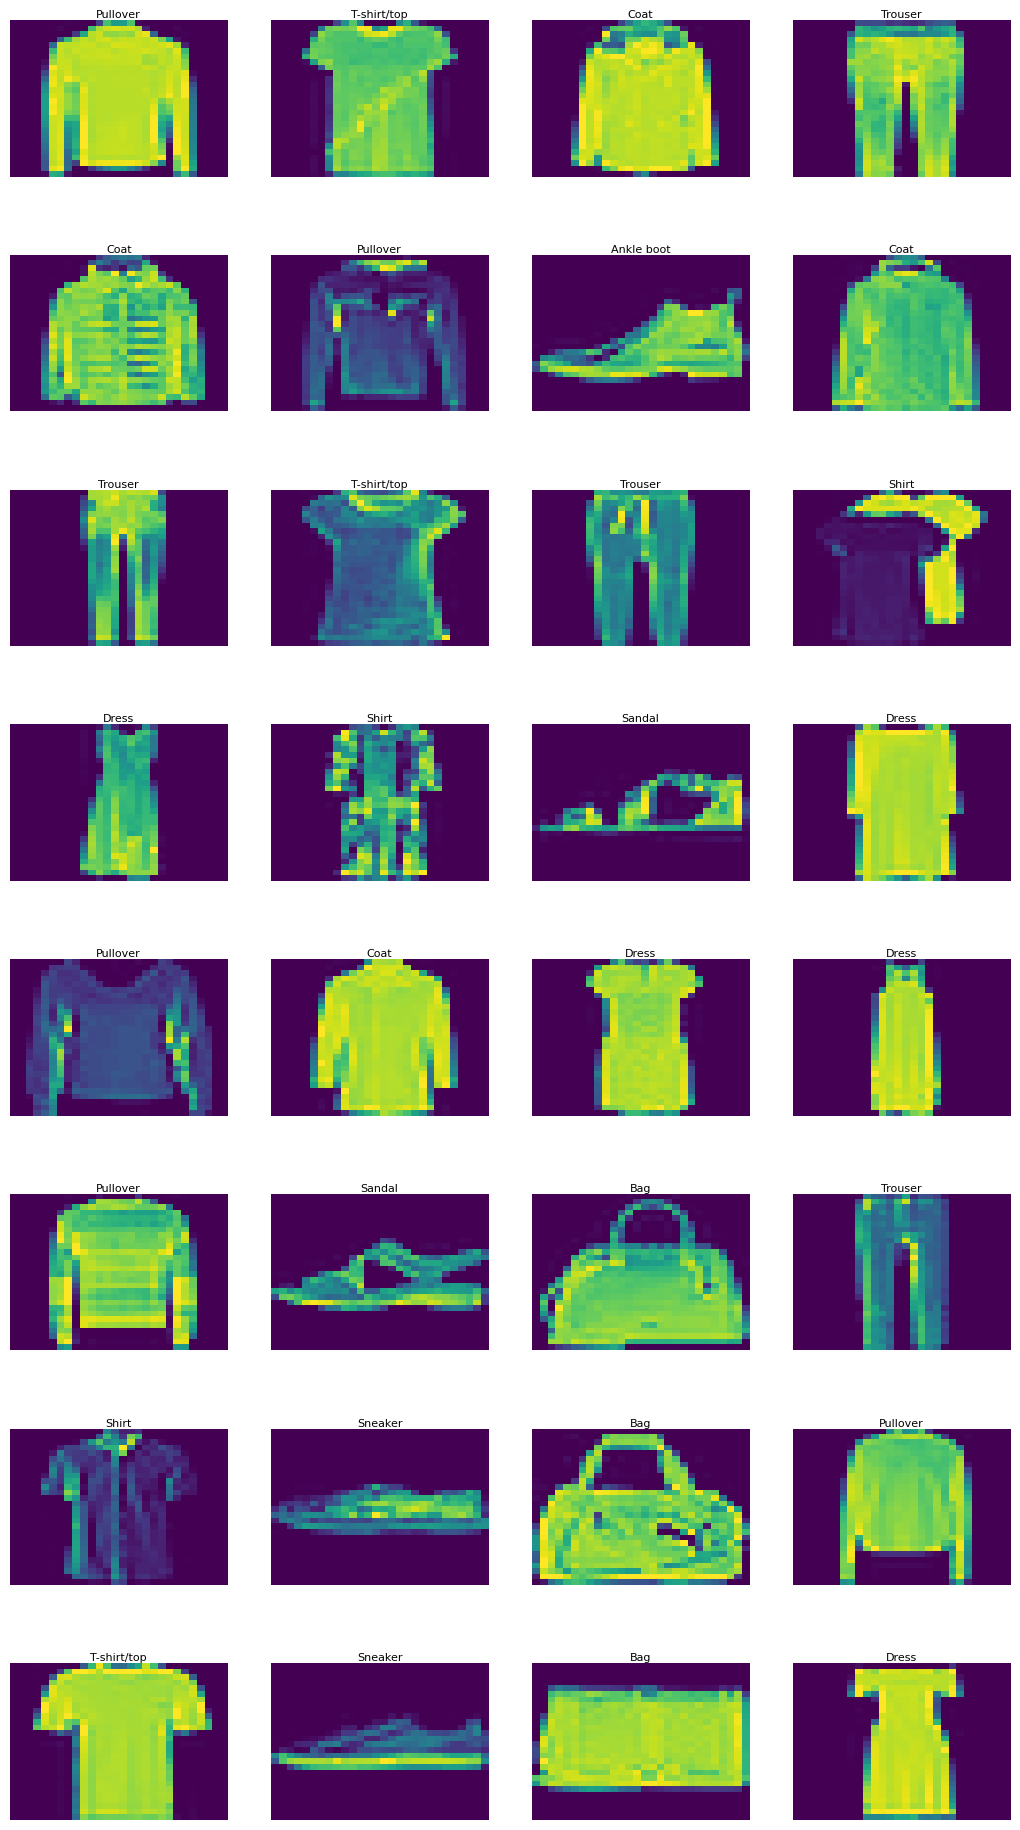

In [16]:
images, labels = next(iter(train_loader))  # Get a single batch

display_image_grid(images=images, labels=labels, class_names=class_names)

## 4 Train 
#### 4.1 Setup Model

In [8]:
model = VAE(INPUT_DIM, no_categories = num_classes,hidden_dim =  H_DIM, z_dim = Z_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR_RATE)
loss_fn = nn.BCELoss(reduction="sum")

#### 4.2 Training Loop

In [9]:
def train(epochs=EPOCHS):
    model.train()
    for _ in tqdm(range(epochs)):
        for x,l in train_loader:
            x = x.to(DEVICE).view(x.shape[0], -1)
            conditions = F.one_hot(l, num_classes=num_classes).to(DEVICE)

            reconstructed_x, mu, sigma = model.forward(x, conditions)
            reconstruction_loss = loss_fn(reconstructed_x, x)
            kl_div = -1 * torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))
            loss = reconstruction_loss + kl_div
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

#### 4.3 Run training

In [11]:
train()

100%|██████████| 50/50 [06:22<00:00,  7.65s/it]


#### 4.4 Generate Images Based on Supplied Condition

Using the trained Conditional Variational Autoencoder (CVAE), we can generate images conditioned on a specific class label. By providing the class ID as input to the decoder, the model generates images that match the desired category.

##### Process:
1. **Select a Condition:** Choose a class ID (e.g., `3` for dresses in the Fashion MNIST dataset).
2. **Latent Space Sampling:** Generate random latent vectors from a Gaussian distribution.
3. **Decode with Condition:** Pass the latent vectors and the selected class ID into the decoder to generate images.
4. **Visualize Results:** Display the generated images to verify that they align with the specified class.

This approach enables controlled data generation for specific categories, useful for tasks like data augmentation or model evaluation.

In [10]:
def generate(conditions):
    z = torch.rand(len(conditions),Z_DIM).to(DEVICE)
    c = F.one_hot(torch.tensor(conditions, dtype=torch.int64), num_classes=num_classes).to(DEVICE)
    z = torch.cat((z, c), dim=1)
    with torch.no_grad():
        output = model.decode(z).view(-1, 1, 28, 28)
    return output

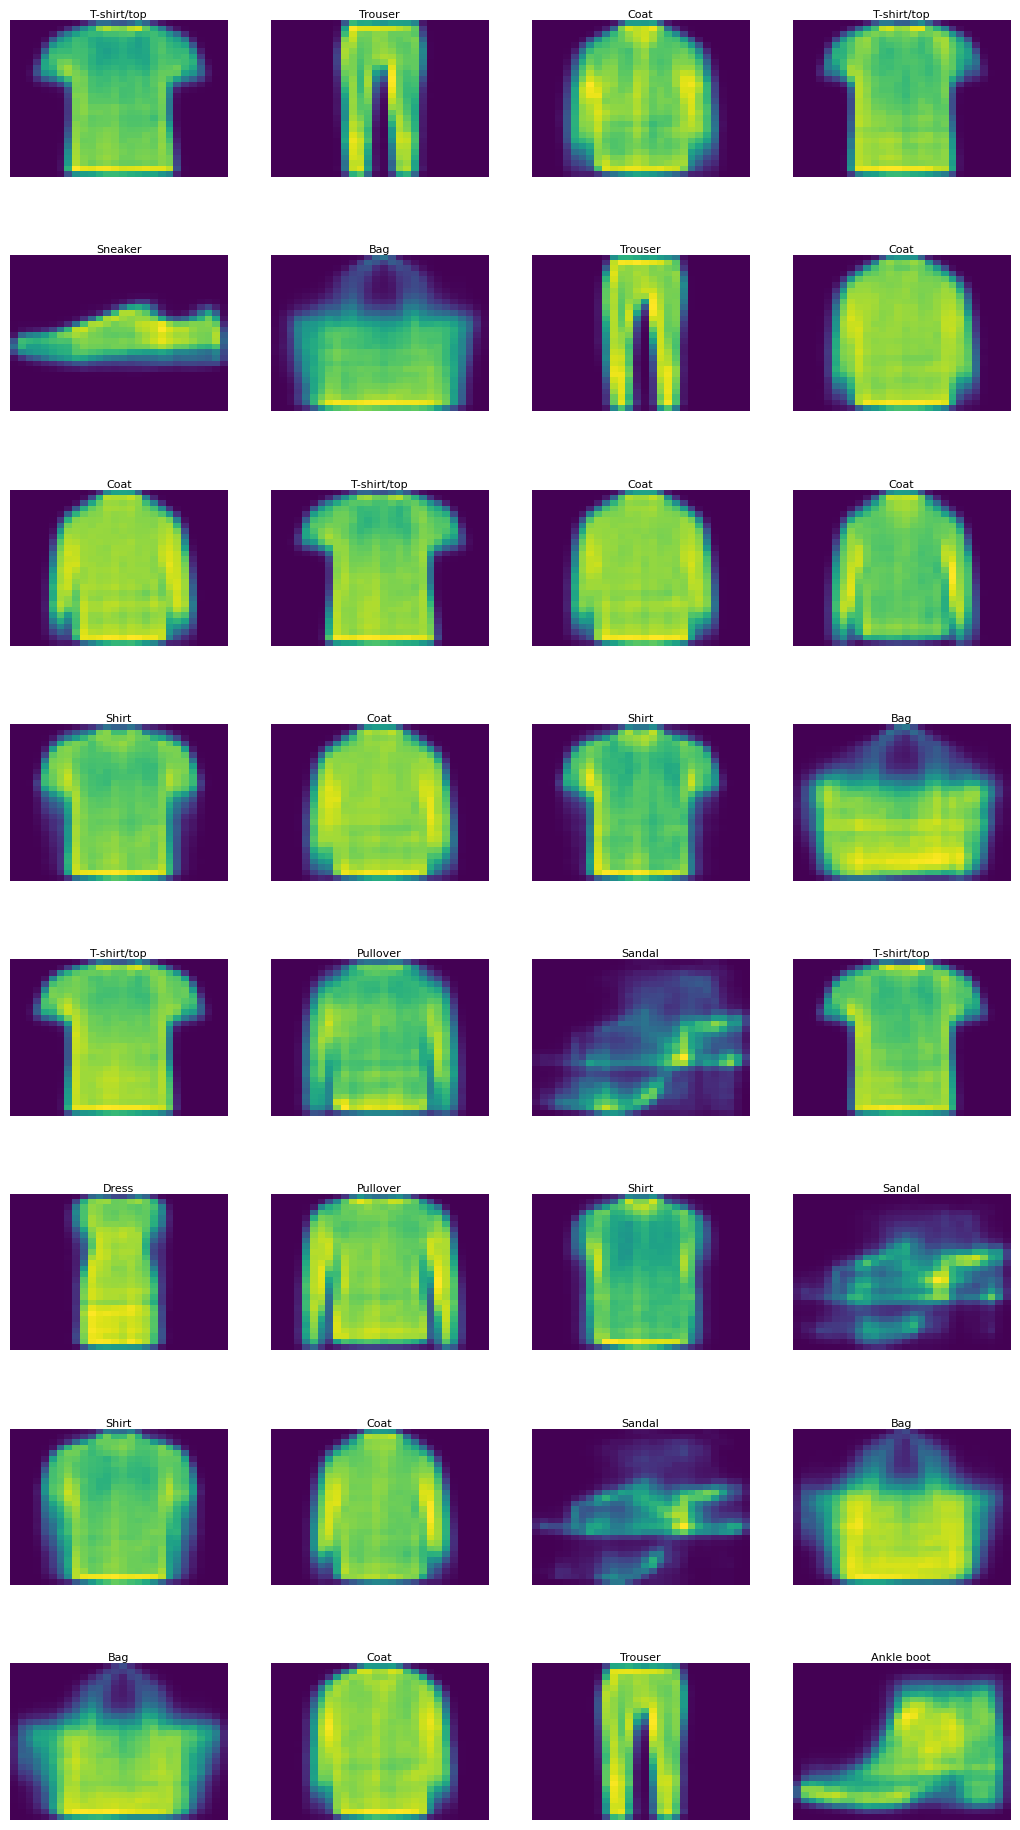

In [12]:
conditions = [random.randint(0, num_classes-1) for _ in range(BATCH_SIZE)]
imgs = generate(conditions).to('cpu')
display_image_grid(imgs, labels=conditions, class_names=class_names, figsize=(10,20))

#### 4.5 Interpolation

One advantage of a Conditional Variational Autoencoder (CVAE) is its ability to generate variations within a specific class by sampling and interpolating in the latent space. By fixing the condition (class ID) and interpolating between two latent points, we can observe smooth transitions and subtle variations in the generated images for the same category.

#### Process:
1. **Condition Selection:** Specify the desired class IDs for which interpolations will be performed.
2. **Latent Space Sampling:**
   - Randomly sample two latent vectors (`z0` and `z1`).
   - Interpolate between these vectors using a weighting factor (`w`) to create a series of intermediate latent points.
3. **Decode Interpolated Points:** Combine the interpolated latent points with the fixed class condition and pass them through the decoder.
4. **Visualization:** Display the generated images as a grid, showing smooth transitions between the two sampled points while keeping the condition constant.


In [13]:
def interpolations(conditions, no_example=10):
    z0 = torch.rand(len(conditions),Z_DIM).to(DEVICE)
    z1 = torch.rand(len(conditions),Z_DIM).to(DEVICE)
    w = torch.linspace(0, 1, no_example).view(no_example, 1, 1).to(DEVICE)
    z = (w * z0 + (1 - w) * z1).transpose(0, 1).reshape(len(conditions) * no_example, Z_DIM)
    c = F.one_hot(torch.tensor(conditions, dtype=torch.int64), num_classes=num_classes).to(DEVICE)
    c = c.repeat_interleave(no_example, dim=0)  # Repeat each condition no_example times
    z = torch.cat((z, c), dim=1)
    with torch.no_grad():
        output = model.decode(z).view(-1, 1, 28, 28)
    return output

#### Output:

The resulting grid shows a series of interpolated images for each specified condition. Each row corresponds to a class condition, and the columns represent smooth transitions between two random latent points for that class.

This method highlights the CVAE’s ability to generate controlled variations and provides insights into how the model encodes class-specific features in the latent space.

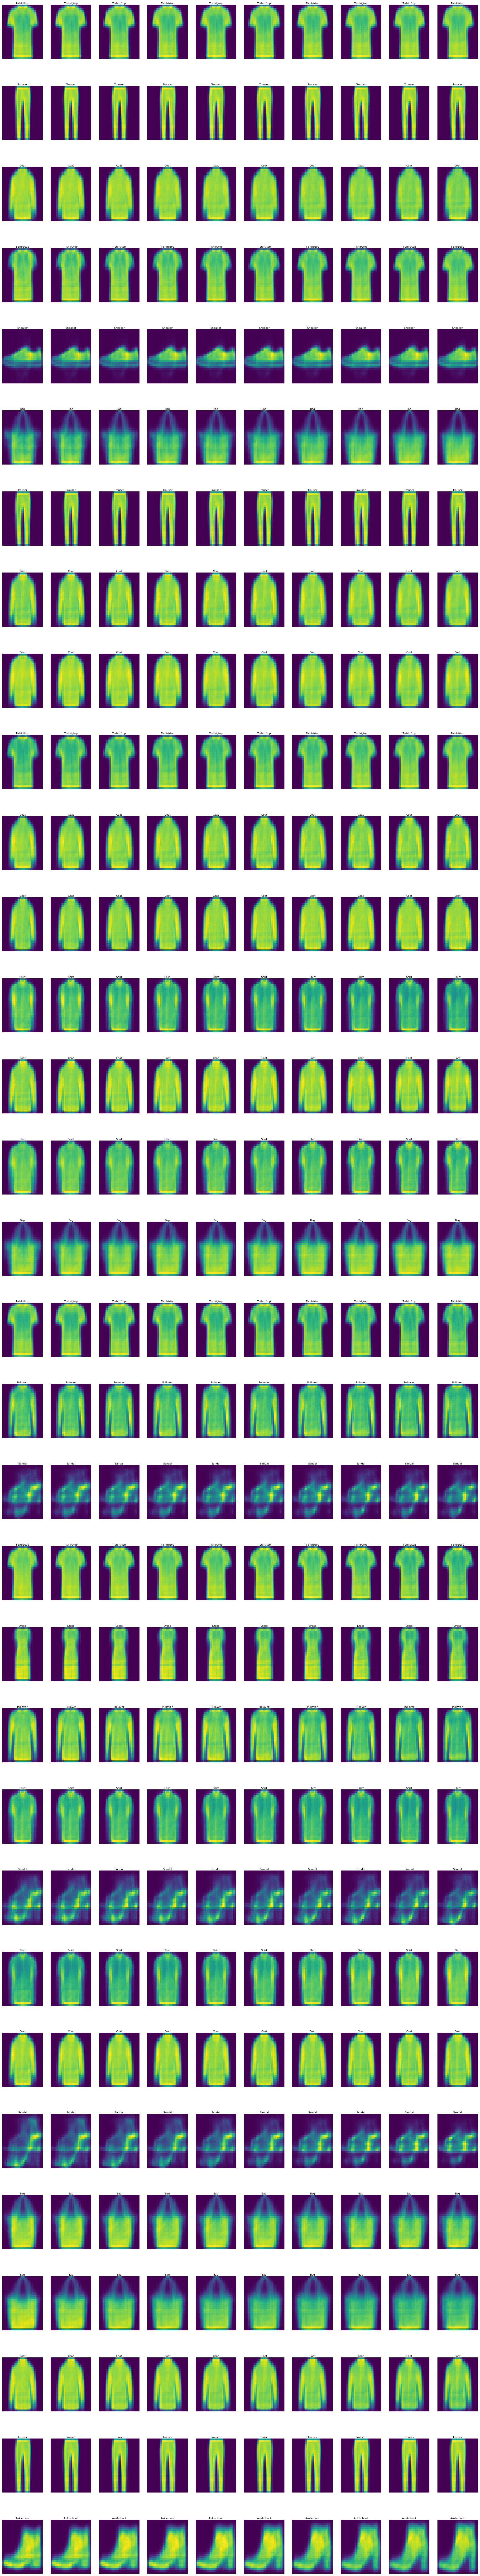

In [14]:
samples = 10
imgs = interpolations(conditions, no_example=samples).to('cpu')
display_image_grid(imgs, labels=[item for item in conditions for _ in range(samples)], class_names=class_names, num_cols=samples, figsize=(20,120))